In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
#import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02514/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

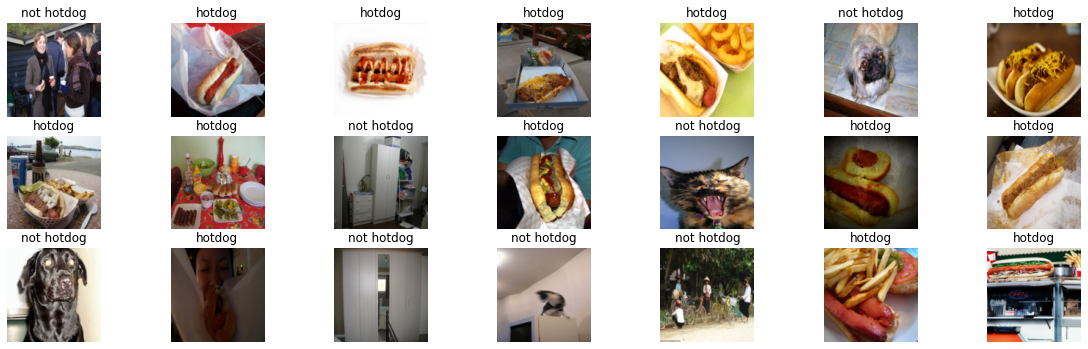

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [6]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Now create a model and train it!


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*4*4*4*4, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(x)
        return x


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()

#         self.convolutional = nn.Sequential(
#             nn.Conv2d(3, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(32, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)
#         )

#         self.fully_connected = nn.Sequential(
#                 nn.Linear(64*4*4*4*4, 64),
#                 nn.ReLU(),
#                 nn.Linear(64, 1),
#                 nn.ReLU(),
#                 nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.convolutional(x)

#         x = x.view(x.size(0), -1)
#         x = self.fully_connected(x)

#         return x



In [8]:
model = Net()
print(model)

Net(
  (convolutional): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=16384, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): ReLU()
    (4): Sigmoid()
  )
)


In [ ]:
import torch.optim as optim

###################
# train the model #
###################
def train(model, train_loader, test_loader):
   criterion = nn.BCELoss()
   optimizer = optim.SGD(model.parameters(), lr=0.01)#, momentum=0.9)

   if torch.cuda.is_available():
      model.cuda()

   n_epochs = 10 # you may increase this number to train a final model
   best_accuracy = 0.0 
   for epoch in range(1, n_epochs+1):
      running_train_loss = 0.0
      for data, target in train_loader:
         # move tensors to GPU if CUDA is available
         if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
         # clear the gradients of all optimized variables
         target = target.float()
         predicted_output = model(data)
         optimizer.zero_grad()
         # forward pass: compute predicted outputs by passing inputs to the model
         # calculate the batch loss
         target = target.unsqueeze(1)
         loss = criterion(predicted_output, target)
         # backward pass: compute gradient of the loss with respect to model parameters
         loss.backward()
         # perform a single optimization step (parameter update)
         optimizer.step()
         # update training loss
         running_train_loss +=loss.item()  # track the loss value 

      train_loss_value = running_train_loss/len(train_loader) 
      predicted_output = (predicted_output>0.5).float()
      correct = (predicted_output == target).float().sum()
      # Print the statistics of the epoch 
      print('Completed training batch', epoch, 'Training Loss is: %.4f' %correct)
      
   running_accuracy = 0 
   total = 0 
   
   with torch.no_grad(): 
      for inputs, outputs in test_loader:
         inputs, outputs = inputs.cuda(), outputs.cuda() 
         outputs = outputs.to(torch.float32) 
         predicted_outputs = model(inputs) 
         _, predicted = torch.max(predicted_outputs, 1) 
         total += outputs.size(0) 
         running_accuracy += (predicted == outputs).sum().item() 
   
   print('Accuracy of the model inputs is: %d %%' % (100 * running_accuracy / total))

# model = Net()
# train(model, train_loader, test_loader)

In [10]:
size = 128
aug_transforms = [
    transforms.Compose([transforms.Resize((size, size)), 
                        transforms.ToTensor()]),
    transforms.Compose([transforms.Resize((size*2, size*2)),
                        transforms.RandomCrop(size), 
                        transforms.ToTensor()]),                        
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomHorizontalFlip(), 
                        transforms.ToTensor()]),   
    transforms.Compose([transforms.Resize((size, size)), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    transforms.Compose([transforms.Resize((size*2, size*2)),
                        transforms.RandomCrop(size), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),                      
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomHorizontalFlip(), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
]

In [13]:
batch_size = 64
for trans in aug_transforms:
    trainset = Hotdog_NotHotdog(train=True, transform=trans)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    testset = Hotdog_NotHotdog(train=False, transform=trans)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

    model = Net()
    train(model, train_loader, test_loader)

Completed training batch 1 Training Loss is: 35.0000
Completed training batch 2 Training Loss is: 34.0000
Completed training batch 3 Training Loss is: 26.0000
Completed training batch 4 Training Loss is: 31.0000
Completed training batch 5 Training Loss is: 40.0000
Completed training batch 6 Training Loss is: 32.0000
Completed training batch 7 Training Loss is: 30.0000
Completed training batch 8 Training Loss is: 33.0000
Completed training batch 9 Training Loss is: 38.0000
Completed training batch 10 Training Loss is: 36.0000
Accuracy of the model inputs is: 48 %
Completed training batch 1 Training Loss is: 31.0000
Completed training batch 2 Training Loss is: 33.0000
Completed training batch 3 Training Loss is: 38.0000
Completed training batch 4 Training Loss is: 34.0000
Completed training batch 5 Training Loss is: 31.0000
Completed training batch 6 Training Loss is: 33.0000
Completed training batch 7 Training Loss is: 33.0000
Completed training batch 8 Training Loss is: 32.0000
Complet